In [2]:
import os, sys, torch
sys.path.append(os.path.abspath('../modules'))
sys.path.append(os.path.abspath('../modules/mnist'))
import vae_train as vt
import vae_ortho as vo
import vae_surgery as vs
from vae import VAE
import utility as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

folder = '../data/MNIST/vae'
epochs = 100
batch_size = 100
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

**Figure out the number of steps required to get fraction of 1 below 0.01**

In [60]:
retrain_data = pd.read_csv("../data/MNIST/vae-retrain/checkpoints/training_log_step.csv")
o_rest_data = pd.read_csv("../data/MNIST/vae-o-rest/checkpoints/training_log_step.csv")
o_rest_s_data = pd.read_csv("../data/MNIST/vae-o-rest-s/checkpoints/training_log_step.csv")
o_all_s_data = pd.read_csv("../data/MNIST/vae-o-all-s/checkpoints/training_log_step.csv")
surgery_data = pd.read_csv("../data/MNIST/vae-s/checkpoints/training_log_step.csv")
ld39a_data = pd.read_csv("../data/MNIST/vae-o-all-ld-r39-s/checkpoints/training_log_step.csv")
l39au_data = pd.read_csv("../data/MNIST/vaeu-ou-all-l-r39-su/checkpoints/training_log_step.csv")
ld39au_data = pd.read_csv("../data/MNIST/vaeu-ou-all-ld-r39-su/checkpoints/training_log_step.csv")
ld39su_data = pd.read_csv("../data/MNIST/vaeu-ld-r39-su/checkpoints/training_log_step.csv")
ld10su_data = pd.read_csv("../data/MNIST/vaeu-ld-r10-su/checkpoints/training_log_step.csv")
ld4su_data = pd.read_csv("../data/MNIST/vaeu-ld-r4-su/checkpoints/training_log_step.csv")
l4su_data = pd.read_csv("../data/MNIST/vaeu-l-r4-su/checkpoints/training_log_step.csv")
l39su_data = pd.read_csv("../data/MNIST/vaeu-l-r39-su/checkpoints/training_log_step.csv")
# ld10a_data = pd.read_csv("../data/MNIST/vae-o-all-ld-r10-s/checkpoints/training_log_step.csv")
data = [retrain_data, o_rest_data, o_rest_s_data, o_all_s_data, surgery_data, ld39a_data,\
        l39au_data, ld39au_data, ld39su_data, ld10su_data, ld4su_data, l4su_data, l39su_data]
labels = ["retrain", "o-rest", "o-rest-s", "o-all-s", "s", "lda-39 (10%)", "lau-39 (22%)", "ldau-39 (10%)",\
         "ldsu-39 (22%)", "ldsu-10 (2.5%)", "ldsu-4 (1%)", "lsu-4 (2.2%)", "lsu-39 (22%)"]

smoothing_window = int(34000/500)

retrain_fraction = retrain_data['1 Fraction'].rolling(smoothing_window).mean()
o_rest_fraction = o_rest_data['1 Fraction'].rolling(smoothing_window).mean()
o_rest_s_fraction = o_rest_s_data['1 Fraction'].rolling(smoothing_window).mean()
o_all_s_fraction = o_all_s_data['1 Fraction'].rolling(smoothing_window).mean()
surgery_fraction = surgery_data['1 Fraction'].rolling(smoothing_window).mean()
ld39a_fraction = ld39a_data['1 Fraction'].rolling(smoothing_window).mean()
l39au_fraction = l39au_data['1 Fraction'].rolling(smoothing_window).mean()
ld39au_fraction = ld39au_data['1 Fraction'].rolling(smoothing_window).mean()
ld39su_fraction = ld39su_data['1 Fraction'].rolling(smoothing_window).mean()
ld10su_fraction = ld10su_data['1 Fraction'].rolling(smoothing_window).mean()
ld4su_fraction = ld4su_data['1 Fraction'].rolling(smoothing_window).mean()
l4su_fraction = l4su_data['1 Fraction'].rolling(smoothing_window).mean()
l39su_fraction = l39su_data['1 Fraction'].rolling(smoothing_window).mean()
# ld10a_fraction = ld10a_data['1 Fraction'].rolling(smoothing_window).mean()
fractions = [retrain_fraction, o_rest_fraction, o_rest_s_fraction, o_all_s_fraction, surgery_fraction,\
            ld39a_fraction, l39au_fraction, ld39au_fraction, ld39su_fraction, ld10su_fraction, ld4su_fraction,\
            l4su_fraction, l39su_fraction]

epsilon = 0.01

retrain_steps = np.argmax(retrain_fraction < epsilon)
o_rest_steps = np.argmax(o_rest_fraction < epsilon) 
o_rest_s_steps = np.argmax(o_rest_s_fraction < epsilon) + smoothing_window
o_all_s_steps = np.argmax(o_all_s_fraction < epsilon) + smoothing_window
surgery_steps = np.argmax(surgery_fraction < epsilon)
ld39a_steps = np.argmax(ld39a_fraction < epsilon) + smoothing_window
l39au_steps = np.argmax(l39au_fraction < epsilon) + smoothing_window
ld39au_steps = np.argmax(ld39au_fraction < epsilon) + smoothing_window
ld39su_steps = np.argmax(ld39su_fraction < epsilon) 
ld10su_steps = np.argmax(ld10su_fraction < epsilon) 
ld4su_steps = np.argmax(ld4su_fraction < epsilon) 
l4su_steps = np.argmax(l4su_fraction < epsilon) 
l39su_steps = np.argmax(l39su_fraction < epsilon) 
# ld10a_steps = np.argmax(ld10a_fraction < epsilon) + smoothing_window

retrain_steps, o_rest_steps, o_rest_s_steps, o_all_s_steps, surgery_steps, ld39a_steps, l39au_steps,\
ld39au_steps, ld39su_steps, ld10su_steps, ld4su_steps, l4su_steps, l39su_steps

(641, 25480, 4829, 290, 558, 1079, 183, 212, 115, 113, 111, 105, 102)

Text(0, 0.5, 'Margin')

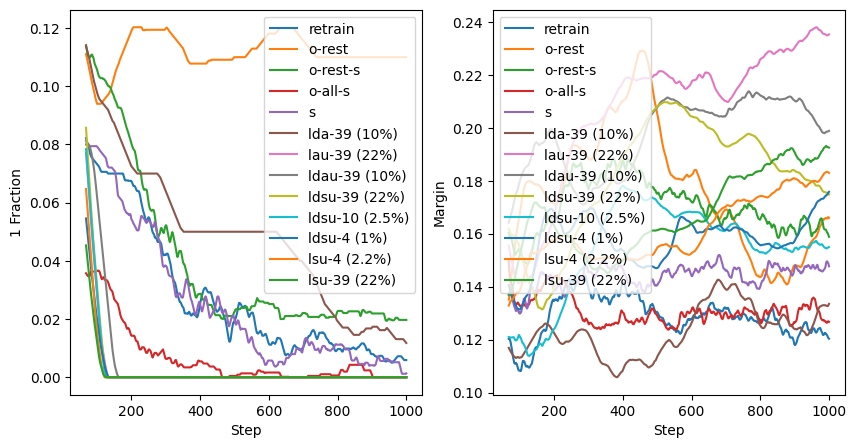

In [55]:
N = 1000
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, f in enumerate(fractions):
    ax[0].plot(range(1, N+1), f[:N], label=labels[i])
    ax[1].plot(range(1, N+1), data[i]["Margin"].rolling(smoothing_window).mean()[:N], label=labels[i])
ax[0].legend()
ax[0].set_xlabel("Step")
ax[0].set_ylabel("1 Fraction")

ax[1].legend()
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Margin")

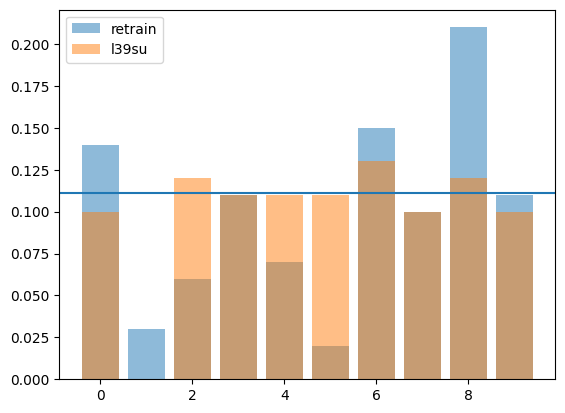

In [59]:
retrain_ambiguity = retrain_data.iloc[retrain_steps]["Margin"]
l39su_ambiguity = l39su_data.iloc[l39su_steps]["Margin"]

steps = 500

plt.bar(range(10), retrain_data.iloc[steps][-10:].to_numpy(), label="retrain", alpha=0.5)
plt.bar(range(10), l39su_data.iloc[steps][-10:].to_numpy(), label="l39su", alpha=0.5)
plt.axhline(1/9)
plt.legend()

In [46]:
target = np.ones(10)/9.; target[1] = 1e-3;
retrain_kl = entropy(retrain_data.iloc[retrain_steps][-10:].to_numpy(), target)
o_rest_s_kl = entropy(o_rest_s_data.iloc[o_rest_s_steps][-10:].to_numpy(), target)
print(retrain_kl, o_rest_s_kl)

NameError: name 'o_rest_s_data' is not defined

In [64]:
int(np.ceil(67/7))

10

In [65]:
import platform as pl
pl.system()

'Darwin'

In [67]:
str(device)

'mps'